In [65]:
import sys
import sklearn
import matplotlib
import numpy as np
from datetime import datetime

from scipy import optimize
from numpy import log, exp
    
from scipy.stats import multivariate_normal as mnorm
from scipy.stats import norm

import matplotlib.pyplot as plt
import keras
import tensorflow
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

import math


In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print('Training Data: {}'.format(X_train.shape))
print('Training Labels: {}'.format(y_train.shape))
print('Testing Data: {}'.format(X_test.shape))
print('Testing Labels: {}'.format(y_test.shape))

Training Data: (60000, 28, 28)
Training Labels: (60000,)
Testing Data: (10000, 28, 28)
Testing Labels: (10000,)


<IPython.core.display.Javascript object>


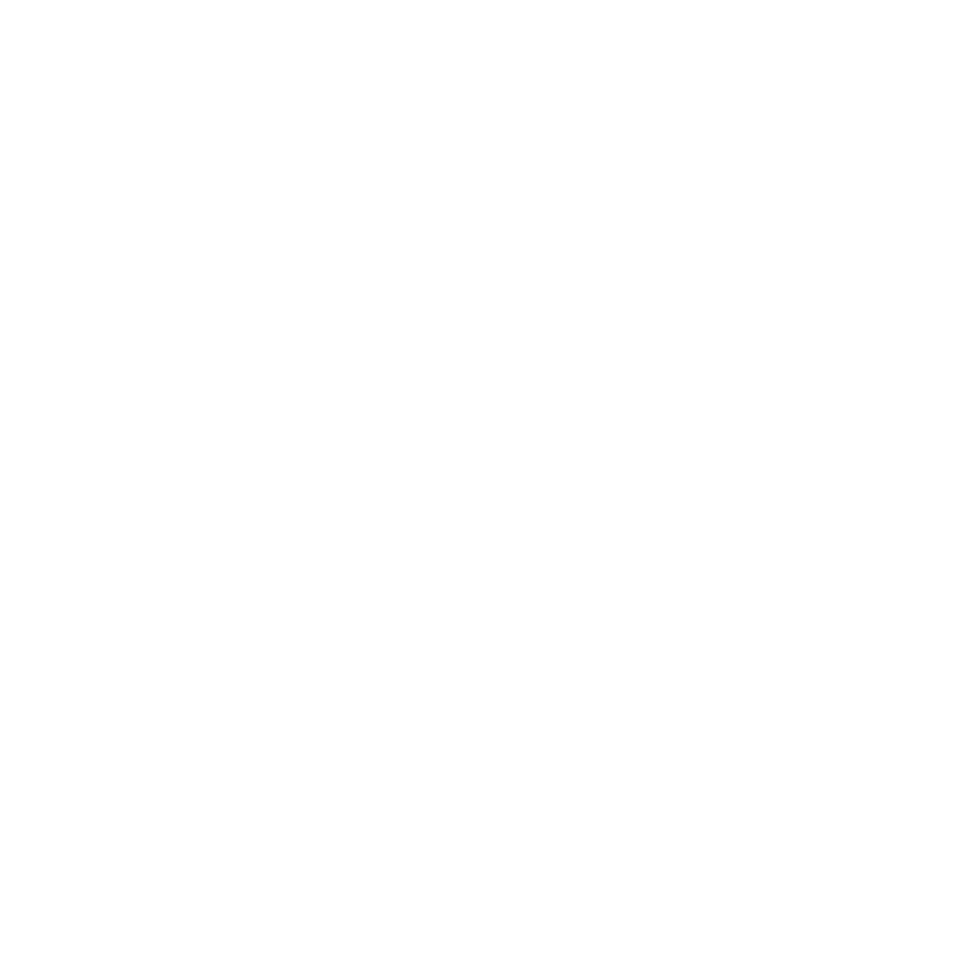

In [4]:
# create figure with 3x3 subplots using matplotlib.pyplot
fig, axs = plt.subplots(3, 3, figsize = (12, 12))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
    ax.matshow(X_train[i])
    ax.axis('off')
    ax.set_title('Number {}'.format(y_train[i]))
    
# display the figure
fig.show()


In [5]:
# preprocessing the images

# convert each image to 1 dimensional array
X_train = X_train.reshape(len(X_train),-1)
X_test = X_test.reshape(len(X_test),-1)
# y_test = y_test

y_classes = set(y_train)

print(X_train.shape)
print(X_train[0].shape)
print(X_test.shape)
print(X_test[0].shape)
print(y_train.shape)
print(y_test.shape)
print(f'Y Class Labels: {y_classes}')

(60000, 784)
(784,)
(10000, 784)
(784,)
(60000,)
(10000,)
Y Class Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [102]:

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))

    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        weights = model.layers[1].get_weights()
        biases = model.layers[1].get_weights()
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # binarize image
    train_norm[train_norm < 0.5] = -1
    train_norm[train_norm >= 0.5] = 1
    # return normalized images
    return train_norm, test_norm

# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        pyplot.subplot(2, 1, 1)
        pyplot.title('Cross Entropy Loss')
        pyplot.plot(histories[i].history['loss'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        pyplot.subplot(2, 1, 2)
        pyplot.title('Classification Accuracy')
        pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    pyplot.show()

# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    pyplot.boxplot(scores)
    pyplot.show()
    
def get_posterior(images,burn_in,steps,eta,beta):
    posterior = np.zeros(images.shape)
    energy_list = list()
    for image_count in range(images.shape[0]):
        if(image_count % 1000 == 0):
            print(image_count)
        image = images[image_count]
        r = np.random.choice([1, -1], size=image.shape)
        for step in range(burn_in+steps):
            for i in range(1,r.shape[0]-1):
                for j in range(1,r.shape[1]-1):
                    p = sample(i,j,r,image,eta,beta)
                    if step >= burn_in and p >= 0.5:
                        posterior[image_count][i,j] = posterior[image_count][i,j]+1
    posterior = 1.0 * posterior / steps
    return posterior
                
def sample(i,j,r,image,eta,beta):
    neighbors = [r[i - 1, j], r[i, j - 1], r[i, j + 1], r[i + 1, j]]
    p = 1.0/(1+np.exp(-2*(eta * image[i,j] + beta * np.sum(neighbors))))
    return p
    
def denoise(images,burn_in,steps,eta,beta):
    print("here")
    posterior = get_posterior(images,burn_in,steps,eta,beta)
    print("done")
    denoised = np.zeros(posterior.shape, dtype=np.float64)
    denoised[posterior >= 0.5] = 1
    denoised[posterior < 0.5] = -1
    return denoised


In [ ]:

trainX, trainY, testX, testY = load_dataset()



# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)

burn_in = 5
steps = 10
eta = 0.5 * np.log(0.7 / (0.7))
beta = 3

# denoise image
trainX = denoise(trainX,burn_in,steps,eta,beta)
testX = denoise(testX,burn_in,steps,eta,beta)

plt.imshow(trainX[0])
plt.show()

trainX = trainX.reshape((trainX.shape[0], 28, 28,1))
testX = testX.reshape((testX.shape[0], 28, 28,1))
# evaluate model
scores, histories = evaluate_model(trainX, trainY)

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)

here
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
